# Ice Future Video Game Predictions

## Purpose

The purpose of this project is to analyze worldwide data from thousands of video games in order to determine what factors help a game to succeed financially. These factors will be used to plan an advertising campaign to target potential high grossing games for 2017.

## Table of Contents
<a href='#General Data Information'>General Data Information</a>

<a href='#Data Preparation'>Data Preparation</a>

<a href='#Data Analysis'>Data Analysis</a>

<a href='#Regional Profiles'>Regional Profiles</a>

<a href='#Hypotheses Testing'>Hypotheses Testing</a>

<a href='#Overall Conclusion'>Overall Conclusion</a>

<a id='General Data Information'></a>
## General Data Information

Initially, a general look at the data is performed.

In [84]:
#Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sc
from scipy import stats as st

game_data = pd.read_csv('/datasets/games.csv')
#Display general information on the data frame
game_data.info()

game_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


**Duplicate Check and Removal**

In addition to a general look at the data sets, the data is checked for any duplicate entries.

In [85]:
#Check for duplicate entries
print('The total number of duplicated entries in the data frame is {}'.format(game_data.duplicated().sum()))

The total number of duplicated entries in the data frame is 0


### General Data Information Conclusion

From the initial look at the data, several of the attributes are missing values. `Name` and `Genre` are only missing two each and should be easy to deal with; however, `Critic_Score`, `User_Score`, and `Rating` are also missing a sizeable portion (sometimes up to 50%) of entries and will require some work to populate this without affecting the accuracy of the data. No duplicate entries required removal.

<a id='Data Preparation'></a>
## Data Preparation

The data must be preprocessed, filling in the missing values noticed from the initial data look, and changing data types as necessary. All columns are first changed to all lowercase to prevent confusion and make the data cleaner to work with going forward. From there, modifications to each column attribute are made.

In [86]:
#Convert all data frame columns to lowercase
game_data.columns = game_data.columns.str.lower()

**`name`**

In the `name` attribute, there are two entries with missing values. These missing values seem to be missing completely at random (MCAR). Since there are so few and they are MCAR, these rows with the missing values can be deleted without impacting the accuracy of the data.

In [87]:
#Remove missing values from name column
game_data['name'].dropna(inplace = True)

**`year_of_release`**

In the `year_of_release` attribute, there are 269 entries with missing values, which make up ~2% of the data. These entries with missing values could be deleted without affecting the overall distribution of the data; however, the missing values could also be replaced with the median value without significantly affecting the overall distribution. The latter is chosen. Additionally, since the attribute consists of a year and doesn't benefit from a fractional representation, the data type is changed from float64 to integer.

In [88]:
#Replaces missing values in the year_of_release column with the median year
median_year_of_release = game_data['year_of_release'].median()
game_data['year_of_release'].fillna(value = median_year_of_release, inplace = True)

#Changes data type to Integer
game_data['year_of_release'] = game_data['year_of_release'].astype('int')

**`genre`**

In the `genre` attribute, there are two entries with missing values. These missing values also seem to be MCAR and therefore, these rows with the missing values can be deleted without impacting the overall data.

In [89]:
#Remove missing values from genre column
game_data['genre'].dropna(inplace=True)

**`critic_score`, `user_score`, and `rating`**

The `critic_score` and `user_score` attributes have a significant number of missing values (nearly half of the total entries). As a crucial part of determining a video game's popularity, these attributes must be dealt with accurately, which is not as simple as using the mean or median value. It is noted that when either of these attributes has a missing value, the other attribute, as well as the `rating` attribute are also missing values. It is anticipated that this may be a result of how or when the data for these specific games was gathered, notably for older games (older than 2000) as a majority of these older games are missing ratings.

Prior to filling in the missing values, the 'tbd' value in the `user_score` attribute must be addressed. As a result of the 'tbd' string being present in `user_score`, the entire attribute is handled as an object type, which will cause difficulties in further analyses. Theoretically, the 'tbd' value is just a missing value, and thus will be treated as one. All the 'tbd' values must be converted to NaN, and `user_score` should also be converted to float64 once all the 'tbd' values are dealt with.

In [90]:
#Replaces all tbd with NaN in the user score column and converts the column to a float data type
game_data['user_score'].replace('tbd', np.NaN, inplace=True)
game_data['user_score'] = game_data['user_score'].astype(float)

Since several of the games are multiplatform games, the `user_score`, `critic_score`, and `rating` from other platforms could be used to fill in missing values.

In [91]:
#Fills in missing values for games on a platform that have user or critic scores on a different platform
game_data['critic_score'].fillna(game_data.groupby(['name'])['critic_score'].transform('first'), inplace=True)
game_data['user_score'].fillna(game_data.groupby(['name'])['user_score'].transform('first'), inplace=True)
game_data['rating'].fillna(game_data.groupby(['name'])['rating'].transform('first'), inplace=True)

It also appears that the values in `critic_score` are closely related to the values of `user_score` except increased by a magnitude of 10. To quantify this relationship, the correlation between the two values is calculated.

In [92]:
print('The correlation between user_score and critic_score is {:.2f}.'.format(game_data['user_score'].corr(game_data['critic_score'])))

The correlation between user_score and critic_score is 0.54.


With a reasonably strong correlation between the two scores, a missing `user_score` can be generated from a `critic_score` and vice versa.

In [93]:
#Purpose of this function is to fill in the missing critic_score based on provided user_score. The critic_score is the
#user_score multiplied by 10
def critic_score_calculator(critic_score, user_score):
    if np.isnan(critic_score) and np.isnan(user_score) == True:
        return critic_score
    elif np.isnan(critic_score) == True:
        calculated_critic_score = user_score * 10
        return calculated_critic_score
    else:
        return critic_score

#Purpose of this function is to fill in the missing user_score based on provided critic_score. The user_score is the
#critic_score divided by 10
def user_score_calculator(critic_score, user_score):
    if np.isnan(critic_score) and np.isnan(user_score) == True:
        return user_score
    elif np.isnan(user_score) == True:
        calculated_user_score = critic_score / 10
        return calculated_user_score
    else:
        return user_score

#Applies the critic_score_calculator and user_score_calculator to the data frame
game_data['critic_score'] = game_data.apply(lambda row: critic_score_calculator(row['critic_score'], row['user_score']), axis = 1)
game_data['user_score'] = game_data.apply(lambda row: user_score_calculator(row['critic_score'], row['user_score']), axis = 1)

With a large portion of the missing values now accurately replaced by the above methods, there aren't many options left for replacing the remaining missing values. As a categorical variable, the missing values in `rating` can be replaced with a "U" to symbolize an unknown rating. For the `critic_score` and `user_score`, due to the sheer number of missing values present, these missing values are replaced with an indicator of 0, such that they can be removed as necessary to avoid altering the data with respect to these unknown values.

In [94]:
game_data['critic_score'].fillna(0, inplace=True)
game_data['user_score'].fillna(0, inplace=True)
game_data['rating'].fillna('U', inplace=True)

**Global Sales**

A new column, `global_sales` is added to the data frame that contains the total worldwide sales for each game.

In [95]:
#Adds a new column to the data frame to calculate the total sales
game_data['global_sales'] = game_data['na_sales'] + game_data['eu_sales'] + game_data['jp_sales'] + game_data['other_sales']

### Data Preparation Conclusion

All missing values have been addressed and several attributes have had their data types changed to improve workability in future analysis. The `critic_score` and `user_score` missing values have been dealt with as best they can; however, a significant number of the missing values had to be filled in with the median values. This may slightly misrepresent the impact these two attributes have on the overall success of the game.

An additional column `global_sales` has been added to better represent the worldwide success of each game. This attribute will be crucial in determining what factors impact a game's overall success. 

<a id='Data Analysis'></a>
## Data Analysis

Now that the data has been preprocessed, it can be analyzed in detail. The gaming industry has evolved considerably over time, so the first thing that is evaluated in greater detail is the games released over time.

### Creating Ideal Data Sample

A histogram is plotted to show the distribution of games released over the years.

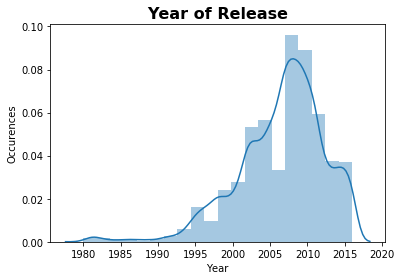

In [96]:
#Creates histogram showing the distribution of the attribute year_of_release
sns.distplot(game_data['year_of_release'], bins = 20)
plt.xlabel('Year')
plt.ylabel('Occurences')
plt.title('Year of Release', weight = 'bold', size =16)
plt.show()

From the histogram displaying the distribution of the `year_of_released`, there are very few games released prior to 1995 in this dataset, whereas the majority of the games are from the 2000s time period. The `global_sales` for games during each of these years can be better understood by generating a heatmap showing the `global_sales` relative to the `year_of_release` and `platform`.

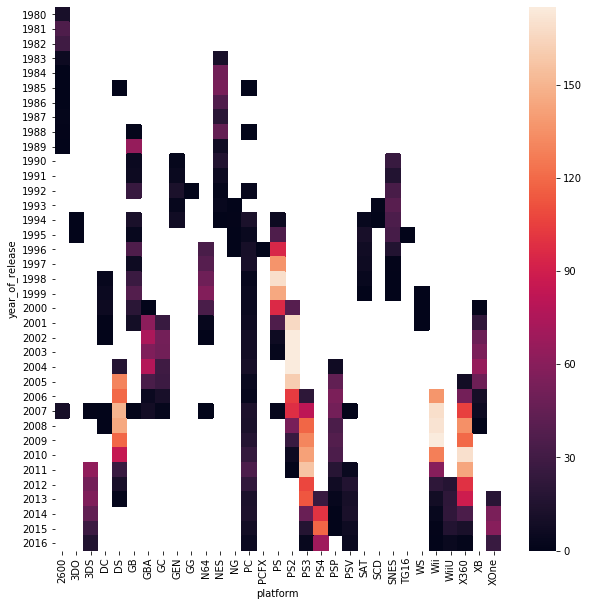

In [97]:
#Creates a heatmap for platform, global_sales, and year_of_release
platform_sales = game_data.pivot_table(index = 'year_of_release', values = 'global_sales', columns = 'platform', aggfunc = 'sum')
fig, hmx = plt.subplots(figsize = (10,10))
hmx = sns.heatmap(platform_sales, vmin = 0, vmax = 175)

There are a few observations that can be made from the heatmap regarding platform sales and the lifetime of certain platforms:
- PC sales has been consistently present since the 1990s; but has never had huge success for total in total sales. Sales have almost always been among the lowest of platform sales.
- The Gameboy's, PlayStation's, and Xbox's have all exhibited the same general cycle regarding the release of new generations of platforms. Initially the old console begins to decline in global sales once the next console version is released. The next generation of the console initially starts at very low sales, but increases over the next few years as owners of the old generation of the console begin to transition over. Eventually, the old generation of the console stops earning sales altogether, typically at the peak of the new generation's sales. The typical timeline of these cycles is around 10 - 12 years, with the platform reaping peak sales for approximately 3 - 5 of those years when it is most relevant, with the fading in and fading out periods making up the remaining years.
- There are a few data anomalies, notably: in the year 2007 there are data entries for platforms that were not longer relevant (2600, DC, and GBA), or not yet released (3DS and PSV); and there are two gaps in the year 1993 for the GB and PC that one would expect would have data. The data anomaly for the year 2007 is a result of there being missing values for this platform that were filled in with the mean `year_of_release`.

With the information from the `year_of_release` histogram and the heatmap, the current data frame can be reduced to a more useful data sample by removing the outliers and all data that is irrelevant for predictions in the upcoming 2017 year. Nearly all data prior to 1995 could be classified as outliers. From 1995 to 2012, there is a lot of useful data on prior platforms and their life cycle; however all of these are irrelevant and non-existent now. In order to best predict sales for 2017, data from 2013 and onward will be used, right when the PS4, Xbox One, and WiiU are getting ready to reach their peak relevance in their lifetime.

In [98]:
#Creates a new data frame of only games released after 1995
useful_game_data = game_data.query('year_of_release >= 2013')

### Selecting Leading Platforms

With a better sample size selected, the data can be evaluated to determine which platforms are the most popular with regards to the highest sales.

In [99]:
#Creates a pivot table for global_sales for each platform type
useful_game_data.pivot_table(index = 'platform', values = 'global_sales', aggfunc = ['count','sum','mean']).sort_values(('sum','global_sales'), ascending = False).head(10)

,count,sum,mean
,global_sales,global_sales,global_sales
platform,,,
PS4,392,314.14,0.801378
PS3,345,181.43,0.525884
XOne,247,159.32,0.645020
3DS,303,143.25,0.472772
X360,186,136.80,0.735484
WiiU,115,64.63,0.562000
PC,189,39.43,0.208624
PSV,358,32.99,0.092151


PlayStation clearly controls the `global_sales` category, holding the top two spots with the PS4 and PS3, in overall sales. Based on this data, as well as the data in the heatmap, for the upcoming release of games in 2017, the PS4 and Xbox One are just reaching their peak sales in their life time cycle. It is highly likely that these two platforms will have some of the most successful games in 2017. WiiU and Nintendo 3DS do not seem to be increasing their sales as one would expect at this point in their life cycle; however, they are the latest platform releases from two previously very successful platforms. PS3 and Xbox 360 also have high `global_sales` but they are losing relevance with the release of the next generation of systems. PS4, Xbox One, WiiU and Nintendo 3DS would be the leading candidates for having the most successful grossing games in 2017.

To get a better understanding of the distribution of `global_sales` for each of the relevant platforms in the chosen time period, a box plot is created.

[(0, 10)]

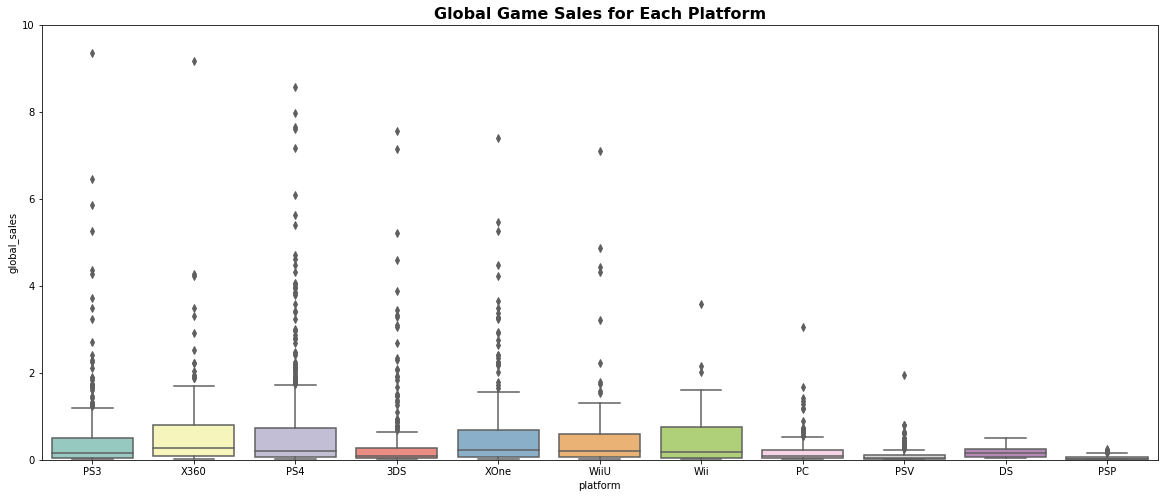

In [100]:
#Creates box plot for global_sales, separated by platform
fig, bx = plt.subplots(figsize = (20, 8))
sns.catplot(x = 'platform', y='global_sales', kind='box', data=useful_game_data, palette = 'Set3', ax=bx)
plt.close(2)
bx.set_title('Global Game Sales for Each Platform', weight ='bold', size=16)
bx.set(ylim=(0, 10))

It is noted that the box plot vertical axis is limited to \\$10 million in sales. There are several games for some platforms that exceed this threshold; however, the useful data in the graph is not visible showing the entire range of sales.

The box plot for `global_sales` for each game shows some interesting information when compares to the `global_sales` per platform:
- Although PS3 was one of the highest grossing platforms, it also had the lowest average sales compared to the other top sellers, PS4, Xbox One, and the Xbox 360. This is likely due to PS3 being at a period in its life cycle where it is losing relevance compared to the increased popularity of the PS4. 
- Although they were released in the same year and are considered to be rivals, the PS4 outperformed the Xbox One in every category from greatest number of individual sales, highest average sales, and highest `global_sales`.

#### Platform-to-Platform Sales

Since many games are multi-platform - playable on several different platforms - an interesting data point will be to evaluate how sales of the same games differ between the platforms. Xbox360, PS3, Xbox One and PS4 are the most popular platforms at this time, so data on `global_sales` for games that are released for each of these platforms will be observed.

In [101]:
#Creates a list of the most popular platforms and generates a data frame consisting of games only on these platforms
relevant_platforms = ['X360', 'PS3', 'XOne', 'PS4']
relevant_platform_data = useful_game_data.query('platform in @relevant_platforms')

#Creates a pivot table for global sales of games that appear on multiple platforms. Only games that appear on all platforms
#are in the final data frame.
multiplatform_games = relevant_platform_data.pivot_table(index = 'name', values = 'global_sales', columns = 'platform', aggfunc = 'sum')
multiplatform_games.dropna(inplace=True)

multiplatform_games.head(20)

platform,PS3,PS4,X360,XOne
name,,,,
Adventure Time: Finn & Jake Investigations,0.08,0.10,0.09,0.05
Alien: Isolation,0.33,1.12,0.27,0.50
Angry Birds Star Wars,0.29,0.22,0.28,0.17
Assassin's Creed IV: Black Flag,3.71,2.86,3.31,2.24
Batman: A Telltale Game Series,0.06,0.09,0.03,0.03
Battlefield 4,3.49,3.58,3.49,2.02
Battlefield: Hardline,0.41,2.11,0.29,1.21
Call of Duty: Advanced Warfare,4.36,7.66,4.28,5.26
Call of Duty: Black Ops 3,1.69,14.63,1.70,7.39


Games on the highest grossing platforms generally average higher `global_sales` than the less popular platforms, as expected. For a majority of the games, the `global_sales` among all the platforms are within \\$1 million of each other; however, there are some rare exceptions, for example Call of Duty: Black Ops 3, where the PS4 sales are \\$7 million more than the next best selling platform. The variations in sales rely on the year the game was released vs. what generations of consoles were most relevant at the time. For years 2013 and 2014, PS3 and Xbox 360 were more relevant, with PS4 and Xbox One being more relevant in the later years.

### Game Ratings

Now that several of the most profitable platforms are known, one of these platforms can be chosen to evaluate how `user_score` and `critic_score` impacts the sales of games. The PS4 is the best selling platform at this time and will be selected. A scatterplot for PS4 games is created for both `user_score` and `critic_score` with respect to `global_sales`. It is noted that since there were a large number of `user_scores` and `critic_scores` that were missing values and were filled with an indicator of 0, these values are excluded from the plots to avoid affecting the overall data.

For PS4 games, the correlation between Critic Score and Global Sales is 0.39, and the correlation between User Score and Global Sales is -0.02


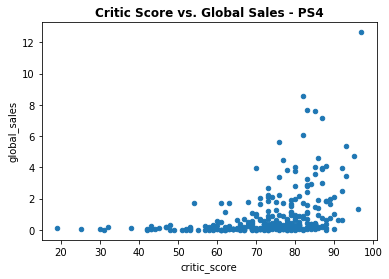

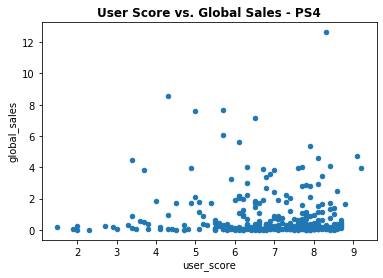

In [102]:
#Creates a data frame for only PS4 games
ps4_game_data = useful_game_data.query('platform == "PS4" and user_score > 0 and critic_score > 0')

#Plots scatterplot for PS4 games for critic score vs global sales
sx1 = ps4_game_data.plot.scatter(x = 'critic_score', y='global_sales')
sx1.set_title('Critic Score vs. Global Sales - PS4', weight ='bold', size = 12)

#Plots scatterplot for PS4 games for user score vs global sales
sx2 = ps4_game_data.plot.scatter(x= 'user_score', y='global_sales')
sx2.set_title('User Score vs. Global Sales - PS4', weight ='bold', size = 12)

#Calculates the correlation coefficient for the above two scatterplots
print('For PS4 games, the correlation between Critic Score and Global Sales is {:.2f}, and the correlation between User Score and Global Sales is {:.2f}'.format(ps4_game_data['critic_score'].corr(ps4_game_data['global_sales']), ps4_game_data['user_score'].corr(ps4_game_data['global_sales'])))

From the scatterplots for the PS4 games, it is evident that there is a slight positive correlation between `critic_scores` and `global_sales`, as nearly all of the low scoring games 60 and lower have barely any global sales. However, at the higher `critic_scores`, many of the highest grossing games also reside. `User_scores`, on the other hand, seem to have fairly random distribution of sales, as some of the mid level `user_score` values have some of the higher `global_sales`. These observations are supported by the calculation of the correlation coefficient which are 0.39 and -0.02 for `critic_score` and `user_score` respectively.

### Sales by Genre

Next, the `global_sales` for each genre are evaluated to determine how the genre of the game affects its success.

In [103]:
#Creates a pivot table grouped by genre
useful_game_data.pivot_table(index = 'genre', values = 'global_sales', aggfunc = ['count','sum', 'mean']).sort_values(('sum','global_sales'), ascending = False).head(15)

,count,sum,mean
,global_sales,global_sales,global_sales
genre,,,
Action,766,321.87,0.420196
Shooter,187,232.98,1.245882
Sports,214,150.65,0.703972
Role-Playing,292,145.89,0.499623
Misc,155,62.82,0.405290
Platform,74,42.63,0.576081
Racing,85,39.89,0.469294
Fighting,80,35.31,0.441375


[(0, 10)]

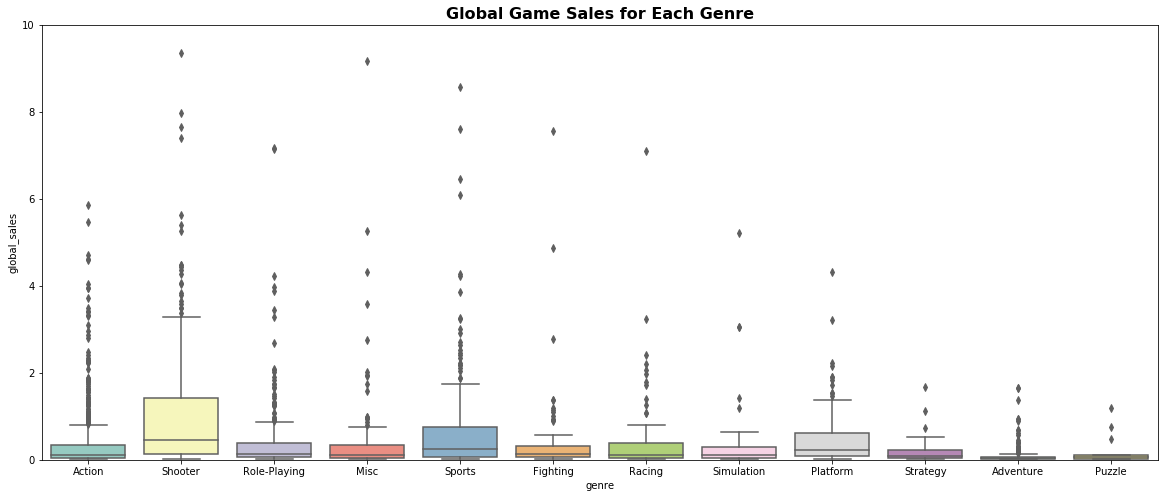

In [104]:
#Creates a box plot for global_sales, separated by game genre
fig, gx = plt.subplots(figsize = (20, 8))
sns.catplot(x = 'genre', y='global_sales', kind='box', data=useful_game_data, palette = 'Set3', ax=gx)
plt.close(2)
gx.set_title('Global Game Sales for Each Genre', weight ='bold', size=16)
gx.set(ylim=(0, 10))

It is noted that the box plot vertical axis is limited to \\$10 million in sales. There are several games in each genre that exceed this threshold; however, the useful data in the graph is not visible showing the entire range.

The box plot for `global_sales`, broken up by genre, shows the following:
- The most profitable genre is action due to the sheer number of games that fall into those genres. However, Shooter games make an impressive amount of profit per game with an average `global_sales` almost double the next highest genre.
- Sports and Role-playing games make the third and fourth most profit, with sports games averaging a higher `global_sale` per game.
- Adventure, Simulation, Strategy, and Puzzle bring in the lowest amount of sales while, unsurprisingly, also have the lowest average `global_sale`.

<a id='Regional Profiles'></a>
## Regional Profiles

Regional profiles are created for each of the three world regions: North America, Japan, and Europe; where sales data is available. For each of these profiles, the five highest grossing platforms and genres are determined. Additionally, in each region the correlation between ESRB ratings and regional sales is calculated.

### North America

In [105]:
useful_game_data.pivot_table(index = 'platform', values = 'na_sales', aggfunc = ['sum', 'mean']).sort_values(
    ('sum','na_sales'), ascending = False).head()

,sum,mean
,na_sales,na_sales
platform,,
PS4,108.74,0.277398
XOne,93.12,0.377004
X360,81.66,0.439032
PS3,63.50,0.184058
3DS,38.20,0.126073


In [106]:
useful_game_data.pivot_table(index = 'genre', values = 'na_sales', aggfunc = ['sum', 'mean']).sort_values(
    ('sum','na_sales'), ascending = False).head()

,sum,mean
,na_sales,na_sales
genre,,
Action,126.05,0.164556
Shooter,109.74,0.586845
Sports,65.27,0.305000
Role-Playing,46.40,0.158904
Misc,27.49,0.177355


In [107]:
useful_game_data.pivot_table(index = 'rating', values = 'na_sales', aggfunc = ['sum', 'mean']).sort_values(
    ('sum','na_sales'), ascending = False).head()

,sum,mean
,na_sales,na_sales
rating,,
M,175.10,0.416905
E,81.71,0.256950
U,72.54,0.085041
E10+,56.38,0.211955
T,51.98,0.138245


For North America, PS4 and Xbox One command the highest overall sales. Action games is the top selling genre with Shooter games a close second, however, as was discovered with the previous box plot, Shooters have a significantly higher mean sale price. Sports is the third with Role-Playing and Misc. rounding out the top 5. Games rated M  are the highest total sames while also being the highest average sales, followed by the E rating. The Unknown rating makes up a significant portion of the `na_sales` which is somewhat concerning since that means there were a lot of successful games cannot be compared back to a specific rating. 

### Japan

In [108]:
useful_game_data.pivot_table(index = 'platform', values = 'jp_sales', aggfunc = ['sum', 'mean']).sort_values(
    ('sum','jp_sales'), ascending = False).head()

,sum,mean
,jp_sales,jp_sales
platform,,
3DS,67.81,0.223795
PS3,23.35,0.067681
PSV,18.59,0.051927
PS4,15.96,0.040714
WiiU,10.88,0.094609


In [109]:
useful_game_data.pivot_table(index = 'genre', values = 'jp_sales', aggfunc = ['sum', 'mean']).sort_values(
    ('sum','jp_sales'), ascending = False).head()

,sum,mean
,jp_sales,jp_sales
genre,,
Role-Playing,51.04,0.174795
Action,40.49,0.052859
Misc,9.20,0.059355
Fighting,7.65,0.095625
Shooter,6.61,0.035348


In [110]:
useful_game_data.pivot_table(index = 'rating', values = 'jp_sales', aggfunc = ['sum', 'mean']).sort_values(
   ('sum','jp_sales'), ascending = False).head()

,sum,mean
,jp_sales,jp_sales
rating,,
U,80.82,0.094748
T,22.84,0.060745
E,15.98,0.050252
M,14.87,0.035405
E10+,6.27,0.023571


For Japan, Nintendo 3DS, PS3, and PSV make up the top 3 platforms, which is quite different from North America, with Nintendo 3DS having the highest average sales. None of the Xbox platforms make an appearance in the top 5. For genre, role-playing games command the highest sales as well as the highest average sales in the top 5. Shooter genre, which was a huge part of the North American profile, is only fifth in genres in terms of success. For ESRB Rating, the unknown rating makes up a significant portion of the sales which is unfortunate. T, E, M, and E10+ make up the rest of the top 5 in that order. 

### Europe

In [111]:
useful_game_data.pivot_table(index = 'platform', values = 'eu_sales', aggfunc = ['sum', 'mean']).sort_values(
    ('sum','eu_sales'), ascending = False).head()

,sum,mean
,eu_sales,eu_sales
platform,,
PS4,141.09,0.359923
PS3,67.81,0.196551
XOne,51.59,0.208866
X360,42.52,0.228602
3DS,30.96,0.102178


In [112]:
useful_game_data.pivot_table(index = 'genre', values = 'eu_sales', aggfunc = ['sum', 'mean']).sort_values(
    ('sum','eu_sales'), ascending = False).head()

,sum,mean
,eu_sales,eu_sales
genre,,
Action,118.13,0.154217
Shooter,87.86,0.469840
Sports,60.52,0.282804
Role-Playing,36.97,0.126610
Racing,20.19,0.237529


In [113]:
useful_game_data.pivot_table(index = 'rating', values = 'eu_sales', aggfunc = ['sum', 'mean']).sort_values(
    ('sum','eu_sales'), ascending = False).head()

,sum,mean
,eu_sales,eu_sales
rating,,
M,156.67,0.373024
E,85.49,0.268836
U,61.19,0.071735
E10+,45.20,0.169925
T,43.68,0.116170


For Europe, PS4 and PS3 are the dominant platforms, followed by Xbox One, Xbox360, and Nintendo 3DS. PS4 has the highest average sales for the top 5. Action games is the top genre, followed by Shooter which has the highest average sales similar to North America. Rated M is the top selling rating, followed by E, the unknown ratings, E10+ and T. Mature ratings have the highest average sales for the top 5. 

### Regional Profile Conclusion

From the regional profiles, it can be shown that North America and Europe have extremely similar profiles for platforms, genres, and ratings with only a few minor differences, mainly the Xbox consoles are slightly more popular in North America than Europe. The Mature rating dominates the market in Europe and North America with E rated games being the next most popular.

Japan has a vastly different profile compared to both North America and Europe. In Japan, the Nintendo 3DS being the most popular platform, leading all sales. Xbox360 is nonexistent in the top sales. For genre, Role-playing leads in sales while being at the bottom of the top 5 in North America and Europe. Shooter games are only fifth compared to their huge popularity and success in North America and Europe. For rating, a significant portion of the Japan sales are the unknown ratings, which make it difficult to accurately assess rating's impact on sales. However, from the data available, it seems that M rated games are the least popular, which is opposite North America and Europe.

North America holds the majority of the market share, with Europe lagging behind by almost half the sales. Japan is nearly insignificant, making up only about 10% of the market. 

<a id='Hypotheses Testing'></a>
## Hypotheses Testing

The following hypotheses are to be tested:

- Average user ratings of the Xbox One and PC platforms are the same.
- Average user ratings for the Action and Sports genres are different.

**User Ratings for Xbox One and PC**

The first hypothesis that will be tested is that the average user ratings of the Xbox One and PC platforms are the same. Xbox is made by Microsoft, who are also very familiar and involved with the PC gaming scene which could result in similar quality and ratings between the two platforms.

The null hypothesis is that there is no difference between user ratings on the Xbox One and PC, which is the original hypothesis. The alternative hypothesis is that user ratings between these two platforms do differ.

To test the hypothesis, the student t-test will be applied to the two samples of "PC" and "Xbox One" games, specifically for the `user_scores` attribute. The critical statistical significance level is set at 5\%. In order to accurately apply this method, data must be separated into the two samples, and the variances of both samples must be compared:

In [114]:
#Separates data into the two platforms of interest
xbone_games = useful_game_data.query('platform == "XOne"')
pc_games = useful_game_data.query('platform == "PC"')

#Compares variance for two platforms of interest
print('Xbox One games - User Rating variance: {:.2f}'.format(np.var(xbone_games['user_score'])))
print('PC games - User Rating variance: {:.2f}'.format(np.var(pc_games['user_score'])))

Xbox One games - User Rating variance: 7.51
PC games - User Rating variance: 8.04


In [115]:
#Critical statistical significance level
alpha = 0.05

#Null hypothesis is there is no difference in ratings between platforms. Variances are not close enough to be equal
platform_ratings = st.ttest_ind(xbone_games['user_score'], pc_games['user_score'], equal_var = False)

print('p-value: ', platform_ratings.pvalue)

if (platform_ratings.pvalue < alpha):
    print('We reject the null hypothesis')
else:
    print("We can't reject the null hypothesis")

p-value:  0.2020068695651967
We can't reject the null hypothesis


The null hypothesis that there is not a difference between user ratings for the Xbox One and PC cannot be rejected as the p-value is at 20%. The average `user_score` for each platform will be calculated to verify. 

In [116]:
#Calculates mean user scores for each of the two samples of interest
xbone_mean_rating = xbone_games['user_score'].mean()
pc_mean_rating = pc_games['user_score'].mean()

print('The Xbox One has an average user game rating of {:.2f}'.format(xbone_mean_rating))
print('The PC has an average user game rating of {:.2f}'.format(pc_mean_rating))

The Xbox One has an average user game rating of 5.54
The PC has an average user game rating of 5.19


Although there is a fair difference between mean values of `user_score`, the null hypothesis cannot be rejected from the results of the Student t-test.

**User Ratings for Action and Sports Genre**

The hypothesis that will be tested is that the average user ratings for the Action and Sports Genre are different.

The null hypothesis in this case is that there is no difference between user ratings for the Action and Sports Genre. The alternative hypothesis is that user ratings between these two genres do differ, which is consistent with the original hypothesis.

To test the hypothesis, the student t-test will be applied to the two samples of "Action" and "Sports" games, specifically for the `user_scores` attribute. The critical statistical significance level is set at 5\%. In order to accurately apply this method, data must be separated into the two samples, and the variances of both samples must be compared:

In [117]:
#Separates data into the two platforms of interest
action_games = useful_game_data.query('genre == "Action"')
sports_games = useful_game_data.query('genre == "Sports"')

#Compares variance for two platforms of interest
print('Action games - User Rating variance: {:.2f}'.format(np.var(action_games['user_score'])))
print('Sports games - User Rating variance: {:.2f}'.format(np.var(sports_games['user_score'])))

Action games - User Rating variance: 12.34
Sports games - User Rating variance: 6.21


In [118]:
#Critical statistical significance level
alpha = 0.05

#Null hypothesis is there is no difference in ratings between genres. Variances are not close enough to be equal
genre_ratings = st.ttest_ind(action_games['user_score'], sports_games['user_score'], equal_var = False)

print('p-value: ', genre_ratings.pvalue)

if (genre_ratings.pvalue < alpha):
    print('We reject the null hypothesis')
else:
    print("We can't reject the null hypothesis")

p-value:  0.2873525225709065
We can't reject the null hypothesis


The null hypothesis that there is not a difference in user ratings for the Sports and Action genre cannot be rejected. The p-value is too high to suggest that there is a difference in ratings. The average `user_score` for each genre will be computed to compare. 

In [119]:
#Calculates mean user scores for each of the two samples of interest
action_mean_rating = action_games['user_score'].mean()
sports_mean_rating = sports_games['user_score'].mean()

print('The Action genre has an average user game rating of {:.2f}'.format(action_mean_rating))
print('The Sports genre has an average user game rating of {:.2f}'.format(sports_mean_rating))

The Action genre has an average user game rating of 4.12
The Sports genre has an average user game rating of 4.35


The average `user_score` between the two genres is close, as expected.

<a id='Overall Conclusion'></a>
## Overall Conclusion

The purpose of this project was to find patterns in the gaming industry and to identify what factors cause a game to succeed. Using this information, the goal is to predict the next big gaming hits in 2017 and to plan advertising campaigns around them.

Data on game sales from the last several decades was analyzed by filling in missing values, calculating global profits and determining correlations and relationships between the various available attributes.

Since 1995, there has been a consistent life cycle for each new generation of gaming platforms. As the new generation is introduced, the old generation sales begin to fade out until the new generation becomes more popular and begins receiving the majority of the sales between the two generations. This continues with each new generation. For 2017, it was discovered that the PlayStation 4, Xbox One, WiiU, and Nintendo 3DS are in the prime relevance of their life cycle, where sales are at the platform's lifetime peak.

Out of these four prime candidates, it was shown that Xbox and PlayStation are typically the leaders in overall sales; however, this is somewhat attributed to the sheer number of games that are released for these platforms. In the past, the Wii and Nintendo DS have some of the single highest grossing game releases, but for the most part, their average game sales are significantly lower than Xbox or PlayStation. Xbox and PlayStation are safe and consistent sales, but Wii or Nintendo could be an interesting gamble for 2017.

For game ratings, `user_score` barely had any correlation with global sales, whereas `critic_score` had a fairly strong positive correlation with global sales.

Action games lead in overall sales, but similar to Xbox and PlayStation platforms, this is a result of the sheer number of games that fall into this category. Shooter games have the highest average sales per game as well as the 2nd most `global_sale` behind Action games which would set up a game from the Shooter genres as a potential big winner in 2017.

North America and Europe make up over 90% of the gaming market and have similar common interests with Xbox and PlayStation being the leading platforms, and Action and Shooter games being the leading genres. Japan attracts some of the less popular genres and platforms, but the significantly lower sales here doesn't warrant special consideration. For the prime locations, M rated games are the best sellers.

Two hypotheses were tested in regards user ratings between different platforms and genres; however, since user ratings do not have a notable correlation on sales, these hypotheses are unimportant.

Based on all this data, the 2017 advertising campaign should focus on new Shooter releases for the PS4 primarily, with a secondary focus on Xbox One. Action games as a whole should demand a portion of the campaign, simply due to the sheer amount of releases that fall under these genres, and their general success, especially if they receive highly positive critic reviews. The single best opportunity for a massively successful game would be focusing on a Shooter Game on either of the two previously mentioned platforms, especially if it receives positive critic reviews.